# Phase Transitions

 This paper trys to reproduce the results found in https://arxiv.org/pdf/1704.00080

1. What Figure 1 Actually Is (Important)

Figure 1 in the paper shows:

(a) Scatter of the first two PCA projections
(b) Mean absolute value of the first PCA component vs temperature

No learning labels are used in PCA. Temperature is used only after PCA.

In [3]:
import h5py
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from helpers import *

### Importing Data in Python

One thing to be aware of is that in R, matrices are column-major (Fortran-ordered) whereas in Python / NumPy, arrays are row-major (C-ordered). So we need to transpose X.

In [4]:
filename = input("Enter the HDF5 filename to load: ")

with h5py.File(f"{filename}.h5", "r") as f:
    X = f["configs"][:].T # Transpose to get samples as rows
    temps = f["temps"][:]
    L = f["L"][()]
    model = f["model"][()].tobytes().decode('utf-8')

In [5]:
print(X.shape)
print(len(temps))

(20000, 256)
20000


### Performing PCA
The paper uses standard linear PCA.

In [6]:
pca = PCA(n_components=None)
Z = pca.fit_transform(X)

#### Figure 3(a): Explained Variance by Components
Relative variances $\tilde{\lambda}_n$ obtained from the raw Ising configurations, with the horizontal axis indicating corresponding component labels.

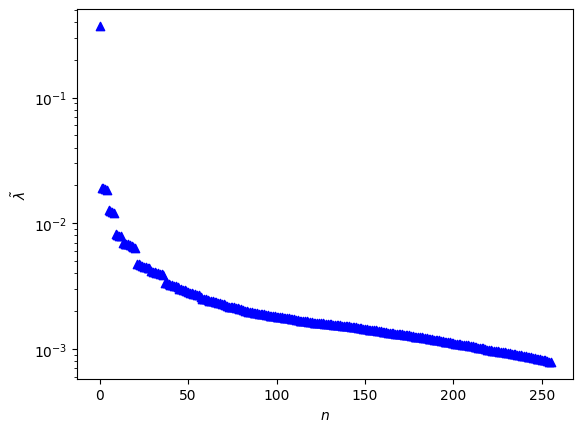

In [7]:
fig, ax = plt.subplots(1, 1)
ax.set_yscale("log")
ax.scatter(np.arange(0, len(pca.explained_variance_)), pca.explained_variance_ratio_, c='blue', marker='^')
ax.set_ylabel(r"$\tilde{\lambda}$")
ax.set_xlabel("$n$")
plt.savefig('PCA_explained_variance_16x16.png')
plt.show()

#### Figure 3(b): PCA Scatter Plot

This is a scatter of $p_1$ vs $p_2$, colored by temperature.

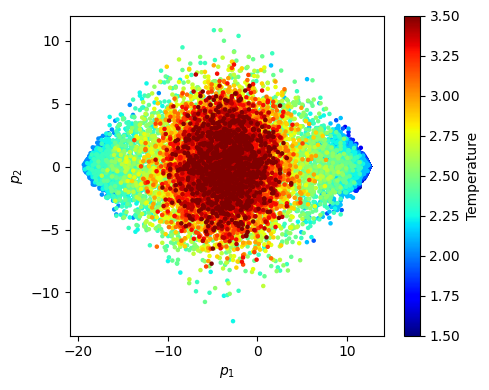

In [8]:
plt.figure(figsize=(5,4))
sc = plt.scatter(
    Z[:,0], Z[:,1],
    c=temps,
    s=5,
    cmap="jet"
)

plt.xlabel(r"$p_1$")
plt.ylabel(r"$p_2$")
plt.colorbar(sc, label="Temperature")
plt.tight_layout()
plt.show()

#### Figure 1(b): <|$p_1$|>/L vs Temperature
The paper bins data by temperature and plots the normalized average mean magnitude of the first principle.

In [9]:
unique_temps = np.unique(temps)
pc1_abs_mean = []
pc1_abs_std = []

for T in unique_temps:
    pc1_vals = np.abs(Z[temps == T, 0])
    pc1_abs_mean.append(pc1_vals.mean())
    pc1_abs_std.append(pc1_vals.std())

pc1_abs_mean = np.array(pc1_abs_mean) / L
pc1_abs_std = np.array(pc1_abs_std) / L


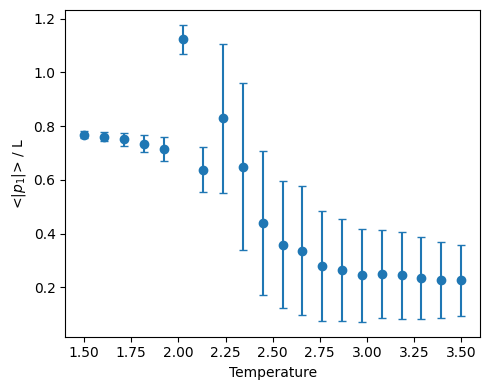

In [10]:
plt.figure(figsize=(5,4))
plt.errorbar(
    unique_temps,
    pc1_abs_mean,
    yerr=pc1_abs_std,
    fmt='o',
    capsize=3
)

plt.xlabel("Temperature")
plt.ylabel(r"<|$p_1$|> / L")
plt.tight_layout()
plt.show()


#### Figure 3(c) <|$p_2$|> vs Temperature
The quantified second leading component as a function of temperature. I have also fit the graph with a 3rd order polynomial so that I can get the peak of the graph which should correspond to the critical temperature $T_c$.

In [11]:
unique_temps = np.unique(temps)
pc2_abs_mean = []
pc2_abs_std = []

for T in unique_temps:
    pc2_vals = np.abs(Z[temps == T, 1])
    pc2_abs_mean.append(pc2_vals.mean())
    pc2_abs_std.append(pc2_vals.std())

pc2_abs_mean = np.array(pc2_abs_mean)
pc2_abs_std = np.array(pc2_abs_std) 

In [12]:
p, cov, chi2_red, p_value = weighted_least_squares_fit(unique_temps, pc2_abs_mean, pc2_abs_std, deg=8)
y_fit = p(unique_temps)

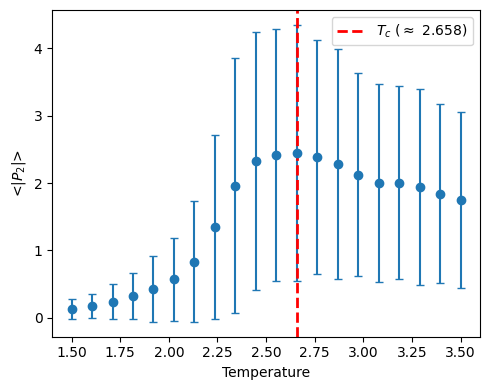

In [13]:
plt.figure(figsize=(5,4))
plt.errorbar(
    unique_temps,
    pc2_abs_mean,
    yerr=pc2_abs_std,
    fmt='o',
    capsize=3
)

# plt.plot(unique_temps, y_fit, '-', label='Fit')

idx = np.argmax(pc2_abs_mean)
plt.axvline(unique_temps[idx], color='red', linestyle='--', linewidth=2, label=r'$T_c$ ($\approx$ %.3f)' % unique_temps[idx])

plt.xlabel("Temperature")
plt.ylabel(r"<|$P_2$|>")
plt.legend()
plt.tight_layout()
plt.show()
